<a href="https://colab.research.google.com/github/DiwakarBasnet/computer-vision-course/blob/unit-7_Video_and_VideoProcessing/notebooks/Unit%207%20-%20Video%20and%20Video%20Processing/Vivit_Fine_tuned_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Video Vision Transformers for Video Classification

## Introduction

Video classification is a task in machine learning where algorithms are trained to recognize and categorize the content of videos into predefined classes or categories by analyzing the spatial and temporal information present in the video frames. The field of video classification has been dominated by deep learning models that leverage convolutional neural networks (CNNs) for a long now. However, the emergence of transformer based models has sparked a revolution across various domains, including computer vision.

Video classification has various applications including action recognition, surveillance, content filtering, and recommendation systems. One of the transformers based algorithms developed for video classification is ViViT, which is also one of the initial successful pure transformer architecture model for video processing and understanding.

The Video Vision Transformer (ViViT) is like an upgraded version of Vision Transformer (ViT), but for videos instead of just images. The reason we need a separate algorithm for videos is because ViT, the one for images, only looks at each frame individually without considering how they relate to each other over time. But understanding how frames connect in a video is crucial for truly understanding its content, so we need a special algorithm, like ViViT, that can handle that temporal aspect. It has set new benchmarks for video classification accuracy. The model outperforms previous methodologies based on deep 3D convolutional networks across a variety of video classification benchmarks.

## Installation

In [1]:
# Install required libraries
!pip install pytorchvideo evaluate accelerate transformers > /dev/null 2>&1

We will now uninstall the latest version of torchvision and depricate it to version 0.14.1 since we are going to use packages and functions in pytorchvideo that are no longer supported in new versions.

In [2]:
!pip uninstall -y torchvision > /dev/null 2>&1
!pip install torchvision==0.14.1 > /dev/null 2>&1

## Authentication

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

We are going to use [UCF101-subset](https://paperswithcode.com/dataset/ucf101) dataset for fine tuning of our ViViT model. We are using just a subset of the original [UCF101-Action Recognition](https://www.crcv.ucf.edu/data/UCF101.php) data set, this is because transformers are GPU hungry and working with huge video data can easily use all our memory on Colab. The original dataset comprises a diverse collection of 101 action categories, covering a wide range of human activities, from sports and dance to everyday actions. This particular [subset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) from [sayakpaul](https://huggingface.co/sayakpaul) contains train, test and validation dataset each with first 10 categories from the original dataset.

In [ ]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

UCF101_subset.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

The above code downloads our subset data from huggingface dataset created by sayakpaul in tar format. So now we need to extract our tar file.

In [ ]:
!tar xf {file_path}

After extraction of tar file we can view the directory structure of newly extracted directory folders using the following code.

In [ ]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -4

UCF101_subset
UCF101_subset/test
UCF101_subset/test/BandMarching
UCF101_subset/test/BandMarching/v_BandMarching_g11_c07.avi


In [ ]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
train_count = len(list(dataset_root_path.glob("train/*/*.avi")))
val_count = len(list(dataset_root_path.glob("val/*/*.avi")))
test_count = len(list(dataset_root_path.glob("test/*/*.avi")))
total_video = train_count + val_count + test_count
print(f"Train videos: {train_count}")
print(f"Test videos: {test_count}")
print(f"Validation videos: {val_count}")
print(f"Total videos: {total_video}")

Train videos: 300
Test videos: 75
Validation videos: 30
Total videos: 405


In the training process, it's crucial to pair each video with its corresponding class label. This facilitates the model's learning by associating video with specific categories. To achieve this, we adopt a systematic approach:
* **Collecting video paths:** The tar file that we just extracted contains a list of video folders, we need to gather file paths of video files within these folders. We utilize the glob method from the pathlib module to find files with the ".avi" extension (*extension of our videos*) within specific directories (*train, val, and test*) under the dataset root path (*dataset_root_path*).
* **Establishing label-video associations:** We construct a dictionary, *label2id*, which maps each class label to the IDs of videos belonging to that class. This enables quick lookup of video IDs associated with a particular class.  Similarly, we create a dictionary, *id2label*, that correlates each video ID with its corresponding class label. This aids in retrieving class labels based on video IDs.

The label-ID correlation is performed twice to establish bidirectional mappings between class labels and their integer IDs. This enables efficient lookup of class labels based on their IDs and vice versa. Having both mappings readily available is convenient during model training and evaluation processes, as it allows for easy conversion between class labels and their numerical representations.

In [ ]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g13_c04.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g25_c07.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g15_c05.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g03_c01.avi'),
 PosixPath('UCF101_subset/train/BandMarching/v_BandMarching_g10_c06.avi')]

In [ ]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
my_label2id = {label: i for i, label in enumerate(class_labels)}
my_id2label = {i: label for label, i in my_label2id.items()}

print(f"Unique classes: {list(my_label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


## Overview of Vision Transformers (ViT)

Before going any further into Video Vision Transformers (ViViT), let's have an overview of ViT over which ViViT are based on. ViT extracts N non-overlapping image patches, performs a linear projection and then raises them into 1D tokens. The sequence of tokens input to the transformer encoder is:
* $Z = [Z_{cls}, Ex_1, Ex_2, ......., Ex_N] + P$

Where the projection by $E$ is equivalent to a 2D convolution. In addition, a learned positional embedding $P$ is added to the tokens to retain positional information, as the subsequent self-attention operations in the transformer are permutation invariant. The tokens are then passed through an encoder consisting of a sequence of $L$ transformer layers. Each $l$ th layer comprises of Multi-Headed Self-Attention (MSA), Layer Normalization (LN) and Multi-Layer Perceptron (MLP) blocks as follows:
* $y^l = MSA(LN(Z^l)) + Z^l$
* $Z^{l+1} = MLP(LN(y^l)) + y^l$

Finally, a linear classifier is used to classify the encoded input.

## Loading ViViT Model

We are going to finetune `ViViT-b-16x2-kinetics400` pre-trained model for video classification. ViViT is an extension of ViT, it is mostly meant to be fine-tuned on a downstream task *(i.e. tasks that follow or depends on output of previous task)* like video classification. Here, `b` indicates base size of the model, `16` is the number of layers used by the model, `2` is the number of attention heads and `kinetics400` is the dataset on which the model was trained on. `Kinetics400` is a video dataset containing over 400,000 video clips across 400 action categories.

In [ ]:
model_checkpt = "google/vivit-b-16x2-kinetics400" # pre-trained ViViT model
batch_size = 4

### Loading Video Processor

`VivitImageProcessor` is an image processing class used by ViViT model, it is part of the model architecture. This class is used for processing video data, which involves a series of preprocessing steps to prepare images for input into the transformer model. This prepares the video for the model by performing various image processing tasks such as resizing, rescaling, cropping, normalizing, etc. This preprocessing of videos ensures that the model receives input data in a consistent and optimal format, which is essential for achieving accurate and reliable predictions. This also enables the model to handle a variety of image sizes and formats effectively.

In [ ]:
from transformers import VivitImageProcessor

image_processor = VivitImageProcessor.from_pretrained(model_checkpt)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

While the `VivitImageProcessor` is primarily used for image preprocessing, the model checkpoint is passed to configure preprocessing steps according to the model's requirements. This ensures that the input data is correctly formatted for the model, which is essential for achieving accurate and reliable predictions.

### Transformer models for video

There are 4 variants of pure transformer based video classification models inspired by ViT.
1. **Spatio-Temporal attention:**
  * Tokenize video sample using tubelet embedding based approach.
  * Pass each token through patch embedding layer and add a positional encoding and pass all tokens through standard transformer encoder.
2. **Factorized Encoder:**
  * Consists of 2 separate transformer encoders; spatial encoder and temporal encoder.
  * First spatial encoder, only models interactions between tokens extracted from same temporal index. The frame level representations are concatenated and then forwarded through a temporal encoder.
  * Second temporal encoder, models interaction between tokens from different temporal indices. Output token of this encoder is finally classified.
  * For spatial transformer, each  token is a tubelet extracted from one clip and all tokens are from same temporal but different spatial index.
  * Although this model has more transformer layers than model 1, but requires fewer floating point operations (FLOPs).
3. **Factorized self-attention:**
  * This model is slightly different than model 1, the MSA layers of the transformer block are broken into 2 parts. The first MSA layer computes self-attention spatially i.e. among all tokens extracted from same temporal index. And the second MSA layer computes self-attention temporally i.e among all tokens extracted from the same spatial index.
  * The order of spatial-then-temporal self-attention or temporal-then-spatial self-attention does not make a difference.
4. **Factorized dot-product attention:**
  * This model is exactly similar to model 1 in terms of architecture, the only difference is the heads in MSA layer of transformer block is divided into 2 halves. Half of the heads compute dot product self attention between tokens extracted from same spatial index and the remaining heads compute dot-product self-attention between tokens extracted from temporal indexes.

Among all 4 models, model 2 was the best performing. All ViViT model variants were trying to combine the spatial and temporal tokens effectively to develop better semantic representation of the video. Model 2 first attends spatial aspect and later the temporal aspect of video sample. This approach is called divided space-time attention.

### Loading model

There are two apporaches of extracting tokens from video:
1. **Uniform-frame sampling:** Uniformly sample $n_t$ frames from the input video clip, embed each 2D frame independently using the same method as ViT and concatenate all these tokens together. If $n_h.n_w$ non-overlapping image patches are extracted from each frame, then a total of $n_t.n_h.n_w$ tokens will be forwarded through the transformer encoder. This method is suitable for scenarios where the temporal information is not critical for the task at hand.

2. **Tubelet Embedding:** This method is an extension of ViT's embedding to 3D and corresponds to a 3D convolution. It is an alternative method in which, non-overlapping, spatio-temporal "tubes" from input volume are extracted and linearly projected. Intuitively, this method fuses spatio-temporal information during tokenization, in contrast to `Uniform frame Sampling` where temporal information from different frames is fused by the transformer. This method is particularly useful tasks that require understanding the dynamics and progression within videos.

The ViViT model uses the tubelet embedding approach to project the video frames into a 3D space, extract patches, and then flatten these patches to create embeddings that capture both spatial and temporal information, which are then used to create embeddings by adding CLS token and positional embeddings.

The `VivitForVideoClassification` is a specific implementation of ViViT model deseigned for video classification tasks, it is built on top of ViViT architecture. It is part of Hugging Face `transformers` library.

In [ ]:
from transformers import VivitForVideoClassification

model = VivitForVideoClassification.from_pretrained(
    model_checkpt,
    id2label=my_id2label,
    label2id=my_label2id,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing dataset

The data we downloaded still needs some construction and series of preprocessing steps to be prepare for sending them as input into the transformer model. These steps include resizing, normalizing, cropping, rescaling, etc. which is done using PyTorch video library.

In [ ]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    RemoveKey,
    Normalize,
    ShortSideScale,
    RandomShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    Compose,
    Lambda,
)

While fine tuning, it is crucial to leverage the pre-trained model's learned features to improve performance of the fine-tuned model, for that purpose it is necessary to preprocess the data in similar way as the data used during pre-training. We'll use the previously loaded image_processor associated with the pre-trained model to obtain the image mean and standard deviation used to normalize pixel values in images

Similarly, we will use the model configuration to find the number of frames to sample using which the clip duration of preprocessed video data is calculated.

In [ ]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
  height = width = image_processor.size["shortest_edge"]
else:
  height = image_processor.size["height"]
  width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

We won't be applying transformations like `RandomShortSideScale`, `RandomCrop`, and `RandomHorizontalFlip` to our validation and test data. These transformations are specifically used on the training dataset to generate additional data within the same category, enhancing the model's ability to generalize. We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function which is tailored for the UCF-101 dataset. It returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class and serves as foundation for for video related operations in the PyTorch Video dataset. So, if you wanted to use a custom dataset not supported off-the-shelf by PyTorch Video, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

In [ ]:
# Training dataset transformations
train_transform = Compose(
  [
    ApplyTransformToKey(
      key="video",
      transform=Compose(
        [
          UniformTemporalSubsample(num_frames_to_sample),
          Lambda(lambda x: x / 255.0),
          Normalize(mean, std),
          RandomShortSideScale(min_size=256, max_size=320),
          RandomCrop(resize_to),
          RandomHorizontalFlip(p=0.5),
        ]
      ),
    ),
  ]
)

# Training dataset
train_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "train"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
  decode_audio=False,
  transform=train_transform,
)

# Validation and test dataset transformations
val_transform = Compose(
  [
    ApplyTransformToKey(
      key="video",
      transform=Compose(
        [
          UniformTemporalSubsample(num_frames_to_sample),
          Lambda(lambda x: x / 255.0),
          Normalize(mean, std),
          Resize(resize_to),
        ]
      ),
    ),
  ]
)

# Validation and test datasets
val_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "val"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
  decode_audio=False,
  transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "test"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
  decode_audio=False,
  transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset).

In [ ]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [ ]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [ ]:
def investigate_video(sample_video):
  """Utility function to investigate the keys present in a video sample."""
  for k in sample_video:
    if k == "video":
      print(k, sample_video["video"].shape)
    else:
      print(k, sample_video[k])

  print(f"Video label: {my_id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 32, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


### Visualization of preprocessed video

We are going to visualize our preprocessed video in a GIF format and for this, we first need to unnormalize our images since a normalized image has floating values between 0 and 1 or -1 and 1 but we want integer values between 0 and 255 to represent a clear image. Images are unnormalized by the reverse process of normalization i.e multiply by standard deviation, add mean and then multiply by 255. Now, we will need to create a gif from the video tensor by first unnormalizing each video frame and then saving it in a gif format by appending those frames using imageio python package. The video tensor is expected to have the following shape: (num_frames, num_channels, height, width).

In [ ]:
import imageio
import numpy as np
from IPython.display import HTML, Image

def unnormalize_img(img):
  """Un-normalizes the image pixels."""
  img = (img * std) + mean
  img = (img * 255).astype("uint8")
  return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
  """Prepares a GIF from a video tensor."""
  frames = []
  for video_frame in video_tensor:
      frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
      frames.append(frame_unnormalized)
  kargs = {"duration": 0.4}
  imageio.mimsave(filename, frames, "GIF", **kargs)
  return filename

def display_gif(video_tensor, gif_name="sample.gif"):
  """Prepares and displays a GIF from a video tensor."""
  video_tensor = video_tensor.permute(1, 0, 2, 3)    # re-arranging dimension of video_tensor
  gif_filename = create_gif(video_tensor, gif_name)
  return Image(filename=gif_filename)

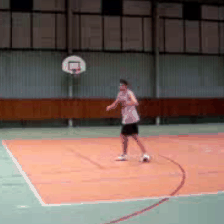

In [ ]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

## Train the model

We'll leverage Trainer from 🤗 Transformers for training the model. To instantiate a Trainer, we will need to define the training configuration and an evaluation metric. We will also use the TrainingArguments class, which contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is remove_unused_columns=False. This one will drop any features not used by the model's call function. By default it's True because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. However, in our case, we need the unused features ('***video***' in particular) in order to create pixel_values which is expected by our model in its inputs.

In [ ]:
from transformers import TrainingArguments, Trainer

model_name = model_checkpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 5

args = TrainingArguments(
    new_model_name,
    auto_find_batch_size=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    num_train_epochs=num_epochs,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Next we'll need a function for evaluating the accuracy of our model for training purpose.

In [ ]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  """Computes accuracy on a batch of predictions."""
  predictions = np.argmax(eval_pred.predictions, axis=1)
  return metric.compute(predictions=predictions, references=eval_pred.label_ids)

We'll also need to create a collate function for creating batches of data for training purpose. Each batch consists of 2 keys, pixel values and labels.

In [ ]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.006500,0.005599,1.000000
1,0.014400,0.005713,1.000000


In [ ]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =        1.2
  eval_accuracy           =        1.0
  eval_loss               =     0.0122
  eval_runtime            = 0:01:00.68
  eval_samples_per_second =      1.434
  eval_steps_per_second   =      0.363


We can now upload our training result to the hub.

In [ ]:
trainer.push_to_hub()

events.out.tfevents.1723289519.c82016455c61.1590.3:   0%|          | 0.00/24.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/355M [00:00<?, ?B/s]

events.out.tfevents.1723289161.c82016455c61.1590.2:   0%|          | 0.00/17.0k [00:00<?, ?B/s]

events.out.tfevents.1723290472.c82016455c61.1590.4:   0%|          | 0.00/411 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

Upload 5 LFS files:   0%|          | 0/5 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/Unspoiled-Egg/vivit-b-16x2-kinetics400-finetuned-ucf101-subset/commit/4806f826060bac7cad2b53668217045c3f287193', commit_message='End of training', commit_description='', oid='4806f826060bac7cad2b53668217045c3f287193', pr_url=None, pr_revision=None, pr_num=None)

## Inference

Now we will try to do inference of our new fine-tuned model. Here we first write a function that runs the inference given a model and video (pre-processed video).

In [ ]:
trained_model = VivitForVideoClassification.from_pretrained(new_model_name)

In [ ]:
sample_test_video = next(iter(val_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 32, 224, 224])
video_name v_BenchPress_g17_c02.avi
video_index 28
clip_index 0
aug_index 0
label 9
Video label: BenchPress


In [ ]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [ ]:
logits = run_inference(trained_model, sample_test_video["video"])

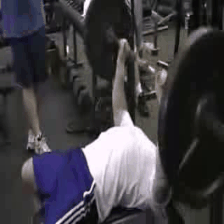

In [ ]:
display_gif(sample_test_video["video"])

In [ ]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: BenchPress
